## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# # 필요한 라이브러리를 설치합니다.
# !pip install timm
# !pip install matplotlib
# !pip install seaborn
# !pip install optuna
# !pip install paddleocr
# !pip install transformers
# !pip install albumentations
# !pip install torch
# !pip install paddlepaddle

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [2]:
import os
import time
import random
import copy

import optuna, math
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision용

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import wandb
from datetime import datetime

# 한글 폰트 설정 (시각화용)
plt.rcParams['font.family'] = ['DejaVu Sans']

import cv2
try:
    import paddleocr
    from transformers import AutoTokenizer, AutoModel
    OCR_AVAILABLE = True
except ImportError:
    OCR_AVAILABLE = False
    print("OCR libraries not installed. Install with: pip install paddleocr transformers")

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
# OCR 텍스트 추출 및 임베딩 클래스
class OCRTextExtractor:
    def __init__(self, lang='en'):
        """OCR 텍스트 추출기 - 문서 상단 20% 영역 집중"""
        if not OCR_AVAILABLE:
            self.available = False
            print("OCR not available - will use image-only mode")
            return
        
        try:
            self.ocr = paddleocr.PaddleOCR(use_angle_cls=True, lang=lang)
            self.tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base')
            self.text_model = AutoModel.from_pretrained('klue/roberta-base')
            self.text_model.eval()
            self.available = True
            print("OCR system initialized successfully")
        except Exception as e:
            self.available = False
            print(f"OCR initialization failed: {e}")
    
    def extract_text_from_image(self, image_path):
        """이미지 상단 20%에서 텍스트 추출"""
        if not self.available:
            return ""
        
        try:
            img = cv2.imread(image_path)
            if img is None:
                return ""
            
            # 상단 20% 영역만 추출 (제목/헤더 정보)
            height = img.shape[0]
            top_region = img[:int(height * 0.2), :]
            
            result = self.ocr.ocr(top_region, cls=True)
            if result is None or len(result) == 0:
                return ""
            
            text_lines = []
            for line in result[0] if result[0] else []:
                if len(line) >= 2:
                    text_lines.append(line[1][0])
            
            return " ".join(text_lines)
        except:
            return ""
    
    def get_text_embedding(self, text, max_length=64):
        """텍스트를 RoBERTa 임베딩으로 변환"""
        if not self.available or not text.strip():
            return torch.zeros(768)
        
        try:
            inputs = self.tokenizer(
                text, 
                truncation=True, 
                padding=True, 
                max_length=max_length,
                return_tensors='pt'
            )
            
            with torch.no_grad():
                outputs = self.text_model(**inputs)
                text_embedding = outputs.last_hidden_state[:, 0, :].squeeze()
            
            return text_embedding
        except:
            return torch.zeros(768)

# 멀티모달 모델 정의
class MultiModalModel(nn.Module):
    def __init__(self, image_model_name, num_classes=17, text_dim=768):
        """이미지 + 텍스트 Late Fusion 모델"""
        super().__init__()
        
        # 이미지 백본 (기존 ConvNeXt 유지)
        self.image_model = timm.create_model(image_model_name, pretrained=True, num_classes=0)
        image_features = self.image_model.num_features
        
        # 텍스트 프로젝션
        self.text_projection = nn.Sequential(
            nn.Linear(text_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128)
        )
        
        # Late Fusion
        self.fusion = nn.Sequential(
            nn.Linear(image_features + 128, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, images, text_embeddings=None):
        # 이미지 특징
        image_features = self.image_model(images)
        
        if text_embeddings is not None:
            # 텍스트 특징 변환
            text_features = self.text_projection(text_embeddings)
            # Late fusion
            combined_features = torch.cat([image_features, text_features], dim=1)
        else:
            # 텍스트 없으면 제로 패딩
            batch_size = image_features.size(0)
            zero_text = torch.zeros(batch_size, 128, device=images.device)
            combined_features = torch.cat([image_features, zero_text], dim=1)
        
        return self.fusion(combined_features)

In [5]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# 데이터셋 클래스를 정의합니다. (Hard Augmentation 포함)
class ImageDataset(Dataset):
    def __init__(self, data, path, ocr_extractor=None, epoch=0, total_epochs=10, is_train=True):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.ocr_extractor = ocr_extractor
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.is_train = is_train
        
        # 적응형 Hard augmentation 확률
        self.p_hard = 0.2 + 0.3 * (epoch / total_epochs) if is_train else 0
        
        # Normal augmentation (기존과 동일)
        self.normal_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
            ], p=0.6),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
            A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
        # Hard augmentation (기존과 동일)
        self.hard_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
                A.Rotate(limit=[-15,15], p=1.0),
            ], p=0.8),
            A.OneOf([
                A.MotionBlur(blur_limit=15, p=1.0),
                A.GaussianBlur(blur_limit=15, p=1.0),
            ], p=0.95),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.9),
            A.GaussNoise(var_limit=(50.0, 150.0), p=0.8),
            A.JpegCompression(quality_lower=70, quality_upper=100, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
    
    def set_epoch(self, epoch):
        """에포크별 Hard augmentation 확률 업데이트"""
        self.epoch = epoch
        self.p_hard = 0.2 + 0.3 * (epoch / self.total_epochs) if self.is_train else 0

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 이미지 augmentation
        if self.is_train and random.random() < self.p_hard:
            img = self.hard_aug(image=img)['image']
        else:
            img = self.normal_aug(image=img)['image']
        
        # 텍스트 추출 및 임베딩
        text_embedding = torch.zeros(768)  # 기본값으로 영벡터 설정
        if self.ocr_extractor is not None and self.ocr_extractor.available:
            try:
                img_path = os.path.join(self.path, name)  # img_path 정의
                text = self.ocr_extractor.extract_text_from_image(img_path)
                if text.strip():  # 텍스트가 있을 때만 임베딩 생성
                    text_embedding = self.ocr_extractor.get_text_embedding(text)
            except Exception as e:
                # OCR 실패 시 영벡터 유지
                pass
    
        return img, target, text_embedding  # 항상 3개 요소 반환

In [6]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    scaler = GradScaler()  # Mixed Precision용
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for batch_data in pbar:
        # 멀티모달 데이터 처리
        if len(batch_data) == 3:  # 텍스트 포함
            image, targets, text_embeddings = batch_data
            text_embeddings = text_embeddings.to(device) if text_embeddings is not None else None
        else:  # 이미지만
            image, targets = batch_data
            text_embeddings = None
            
        image = image.to(device)
        targets = targets.to(device)
        
        # Mixup 적용 (30% 확률)
        if random.random() < 0.3:
            mixed_x, y_a, y_b, lam = mixup_data(image, targets, alpha=1.0)
            with autocast(): 
                preds = model(mixed_x, text_embeddings)
            loss = lam * loss_fn(preds, y_a) + (1 - lam) * loss_fn(preds, y_b)
        else:
            with autocast(): 
                preds = model(image, text_embeddings)
            loss = loss_fn(preds, targets)

        model.zero_grad(set_to_none=True)

        scaler.scale(loss).backward()  # Mixed Precision용
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()  # Mixed Precision용

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [7]:
# validation을 위한 함수 추가
def validate_one_epoch(loader, model, loss_fn, device):
    """
    한 에폭 검증을 수행하는 함수
    - model.eval()로 모델을 평가 모드로 전환
    - torch.no_grad()로 gradient 계산 비활성화하여 메모리 절약
    - 검증 데이터에 대한 loss, accuracy, f1 score 계산
    """
    model.eval()  # 모델을 평가 모드로 전환 (dropout, batchnorm 비활성화)
    val_loss = 0
    preds_list = []
    targets_list = []
    
    with torch.no_grad():   # gradient 계산 비활성화 (메모리 절약)
        pbar = tqdm(loader, desc="Validating")
        for batch_data in pbar:
            # 멀티모달 데이터 처리
            if len(batch_data) == 3:  # 텍스트 포함
                image, targets, text_embeddings = batch_data
                text_embeddings = text_embeddings.to(device) if text_embeddings is not None else None
            else:  # 이미지만
                image, targets = batch_data
                text_embeddings = None
                
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image, text_embeddings)
            loss = loss_fn(preds, targets)  # 손실 계산
            
            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())  # 예측 클래스 저장
            targets_list.extend(targets.detach().cpu().numpy())  # 실제 클래스 저장
            
            pbar.set_description(f"Val Loss: {loss.item():.4f}")
    
    val_loss /= len(loader)  # 평균 손실 계산
    val_acc = accuracy_score(targets_list, preds_list)  # 정확도 계산
    val_f1 = f1_score(targets_list, preds_list, average='macro')  # Macro F1 계산 (대회 평가지표)
    
    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [8]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../data/'

# model config
# model_name = 'tf_efficientnetv2_b3' # 'resnet50' 'efficientnet-b0', ...
# model_name = 'swin_base_patch4_window12_384_in22k'
model_name = 'convnext_base_384_in22ft1k'

# training config
img_size = 384
LR = 2e-4
EPOCHS = 50
BATCH_SIZE = 32
num_workers = 8
EMA = True  # Exponential Moving Average 사용 여부

In [9]:
# Optuna를 사용한 하이퍼파라미터 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    def objective(trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        
        # 간단한 3-fold CV로 빠른 평가
        skf_simple = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf_simple.split(train_df, train_df['target'])):
            # 모델 생성
            model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
            optimizer = Adam(model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()
            
            # 간단한 2 epoch 학습
            for epoch in range(2):
                train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
            
            val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
            fold_scores.append(val_ret['val_f1'])
        
        return np.mean(fold_scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    
    # 최적 파라미터 적용
    LR = study.best_params['lr']
    BATCH_SIZE = study.best_params['batch_size']
    print(f"Best params: {study.best_params}")

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [10]:
# Optuna 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    # 위의 objective 함수와 study 코드
    pass

# K-Fold 적용

In [11]:
# OCR 초기화
print("Initializing OCR system...")
ocr_extractor = OCRTextExtractor(lang='en')

# K-Fold 설정
N_FOLDS = 5  # 5-fold로 설정 (데이터가 적으므로)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# 클래스별 최소 샘플 보장 확인
# for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
#     assert len(np.unique(train_df.iloc[val_idx]['target'])) == 17

# 전체 학습 데이터 로드
train_df = pd.read_csv("../data/train.csv")

# K-Fold 결과를 저장할 리스트
fold_results = []
fold_models = []  # 각 fold의 최고 성능 모델을 저장
fold_class_accuracies = [] # 각 fold의 클래스별 정확도 저장

print(f"Starting {N_FOLDS}-Fold Cross Validation...")

# LR = best_params['lr']
# BATCH_SIZE = best_params['batch_size']

# K-Fold Cross Validation 시작
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*50}")
    
    current_model = model_name
    
    # 현재 fold의 train/validation 데이터 분할
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    # 현재 fold의 Dataset 생성
    trn_dataset = ImageDataset(
        train_fold_df,
        "../data/train/",
        # transform=trn_transform
        ocr_extractor=ocr_extractor,  # OCR 추가
        epoch=0,  # 현재 epoch 전달
        total_epochs=EPOCHS,
        is_train=True
    )
    
    val_dataset = ImageDataset(
        val_fold_df,
        "../data/train/",
        # transform=tst_transform  # 검증에는 증강 적용 안함
        epoch=0,  # validation은 epoch 관계없음
        total_epochs=EPOCHS,
        is_train=False  # validation이므로 hard augmentation 비활성화
    )
    
    # 현재 fold의 DataLoader 생성
    trn_loader = DataLoader(
        trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"Train samples: {len(trn_dataset)}, Validation samples: {len(val_dataset)}")
    
    # 모델 초기화 (각 fold마다 새로운 모델)
    model = MultiModalModel(
        current_model,
        num_classes=17
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)  # Label Smoothing 적용
    optimizer = Adam(model.parameters(), lr=LR)
    
    # Learning Rate Scheduler 추가
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    # 현재 fold의 최고 성능 추적
    best_val_f1 = 0.0
    best_model = None
    
    # 현재 fold 학습
    for epoch in range(EPOCHS):
        # Dataset epoch 업데이트 (적응형 augmentation)
        trn_dataset.set_epoch(epoch)
        
        # Training
        train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
        
        # Validation
        val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
        
        # Scheduler step 추가
        scheduler.step()
        
        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_ret['train_loss']:.4f} | "
              f"Train F1: {train_ret['train_f1']:.4f} | "
              f"Val Loss: {val_ret['val_loss']:.4f} | "
              f"Val F1: {val_ret['val_f1']:.4f}")
        
        # 최고 성능 모델 저장
        if val_ret['val_f1'] > best_val_f1:
            best_val_f1 = val_ret['val_f1']
            best_model = copy.deepcopy(model.state_dict())
            
            # Best 모델 분석
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for image, targets, text_embeddings in val_loader:
                    text_embeddings = text_embeddings.to(device) if text_embeddings is not None else None
                    preds = model(image.to(device), text_embeddings).argmax(dim=1)  # 멀티모달 모델 호출
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(targets.numpy())
            
            # 클래스별 정확도
            fold_class_acc = {}
            for c in range(17):
                mask = np.array(val_targets) == c
                if mask.sum() > 0:
                    fold_class_acc[c] = (np.array(val_preds)[mask] == c).mean()
    
    # 현재 fold 결과 저장
    fold_results.append({
        'fold': fold + 1,
        'best_val_f1': best_val_f1,
        'train_samples': len(trn_dataset),
        'val_samples': len(val_dataset)
    })
    
    fold_models.append(best_model)
    
    print(f"Fold {fold + 1} Best Validation F1: {best_val_f1:.4f}")
    
    fold_class_accuracies.append(fold_class_acc) # 각 fold의 클래스별 정확도 저장

# K-Fold 결과 요약
print(f"\n{'='*60}")
print("K-FOLD CROSS VALIDATION RESULTS")
print(f"{'='*60}")

val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

for result in fold_results:
    print(f"Fold {result['fold']}: {result['best_val_f1']:.4f}")

print(f"\nMean CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Best single fold: {max(val_f1_scores):.4f}")

Initializing OCR system...


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/data/ephemeral/home/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/data/ephemeral/home/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/data/ephemeral/home/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/data/ephemeral/home/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `

OCR system initialized successfully
Starting 5-Fold Cross Validation...

FOLD 1/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.6750: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Epoch  1 | Train Loss: 2.4650 | Train F1: 0.3087 | Val Loss: 1.7187 | Val F1: 0.5207


Val Loss: 1.1325: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch  2 | Train Loss: 1.7216 | Train F1: 0.4314 | Val Loss: 1.1424 | Val F1: 0.6161


Val Loss: 0.8736: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Epoch  3 | Train Loss: 1.3363 | Train F1: 0.5585 | Val Loss: 0.8884 | Val F1: 0.7386


Val Loss: 0.8178: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch  4 | Train Loss: 1.1359 | Train F1: 0.6386 | Val Loss: 0.7964 | Val F1: 0.8006


Val Loss: 0.6912: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch  5 | Train Loss: 1.0318 | Train F1: 0.6888 | Val Loss: 0.6629 | Val F1: 0.8242


Val Loss: 0.6794: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Epoch  6 | Train Loss: 0.9605 | Train F1: 0.7124 | Val Loss: 0.6169 | Val F1: 0.8576


Val Loss: 0.6410: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch  7 | Train Loss: 0.9349 | Train F1: 0.7078 | Val Loss: 0.5870 | Val F1: 0.8866


Val Loss: 0.7326: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Epoch  8 | Train Loss: 0.8560 | Train F1: 0.7206 | Val Loss: 0.6225 | Val F1: 0.8302


Val Loss: 0.5447: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

Epoch  9 | Train Loss: 0.7669 | Train F1: 0.7120 | Val Loss: 0.5657 | Val F1: 0.8929



Val Loss: 0.6074: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 10 | Train Loss: 0.6939 | Train F1: 0.8178 | Val Loss: 0.5525 | Val F1: 0.8784


Val Loss: 0.5710: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Epoch 11 | Train Loss: 0.9070 | Train F1: 0.7592 | Val Loss: 0.5551 | Val F1: 0.8703


Val Loss: 0.5183: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Epoch 12 | Train Loss: 0.7596 | Train F1: 0.8088 | Val Loss: 0.5230 | Val F1: 0.9285


Val Loss: 0.4567: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch 13 | Train Loss: 0.7970 | Train F1: 0.7201 | Val Loss: 0.5056 | Val F1: 0.9289


Val Loss: 0.5253: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Epoch 14 | Train Loss: 0.7693 | Train F1: 0.7907 | Val Loss: 0.5113 | Val F1: 0.9061


Val Loss: 0.5623: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 15 | Train Loss: 0.7133 | Train F1: 0.7926 | Val Loss: 0.5520 | Val F1: 0.9066


Val Loss: 0.6319: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 16 | Train Loss: 0.8586 | Train F1: 0.6883 | Val Loss: 0.5155 | Val F1: 0.9222


Val Loss: 0.4789: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 17 | Train Loss: 0.6439 | Train F1: 0.8408 | Val Loss: 0.4817 | Val F1: 0.9339


Val Loss: 0.5368: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 18 | Train Loss: 0.7371 | Train F1: 0.7773 | Val Loss: 0.5153 | Val F1: 0.9184


Val Loss: 0.4509: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Epoch 19 | Train Loss: 0.6216 | Train F1: 0.8424 | Val Loss: 0.4658 | Val F1: 0.9575


Val Loss: 0.4612: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Epoch 20 | Train Loss: 0.6488 | Train F1: 0.8596 | Val Loss: 0.4716 | Val F1: 0.9448


Val Loss: 0.4085: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 21 | Train Loss: 0.5937 | Train F1: 0.8445 | Val Loss: 0.4428 | Val F1: 0.9541


Val Loss: 0.4594: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 22 | Train Loss: 0.6340 | Train F1: 0.8350 | Val Loss: 0.4634 | Val F1: 0.9332


Val Loss: 0.4223: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Epoch 23 | Train Loss: 0.6213 | Train F1: 0.8168 | Val Loss: 0.4548 | Val F1: 0.9375


Val Loss: 0.4364: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 24 | Train Loss: 0.6059 | Train F1: 0.9052 | Val Loss: 0.4527 | Val F1: 0.9488


Val Loss: 0.4115: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Epoch 25 | Train Loss: 0.6642 | Train F1: 0.8525 | Val Loss: 0.4533 | Val F1: 0.9569


Val Loss: 0.5071: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 26 | Train Loss: 0.7365 | Train F1: 0.7596 | Val Loss: 0.4861 | Val F1: 0.9153


Val Loss: 0.3994: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 27 | Train Loss: 0.6172 | Train F1: 0.8462 | Val Loss: 0.4597 | Val F1: 0.9462


Val Loss: 0.4656: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch 28 | Train Loss: 0.5831 | Train F1: 0.8402 | Val Loss: 0.4502 | Val F1: 0.9523


Val Loss: 0.4215: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Epoch 29 | Train Loss: 0.6992 | Train F1: 0.8055 | Val Loss: 0.4714 | Val F1: 0.9537


Val Loss: 0.4340: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 30 | Train Loss: 0.6753 | Train F1: 0.8118 | Val Loss: 0.4829 | Val F1: 0.9411


Val Loss: 0.3545: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch 31 | Train Loss: 0.5684 | Train F1: 0.8550 | Val Loss: 0.4360 | Val F1: 0.9384


Val Loss: 0.4626: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Epoch 32 | Train Loss: 0.5659 | Train F1: 0.8666 | Val Loss: 0.4850 | Val F1: 0.9369


Val Loss: 0.4196: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch 33 | Train Loss: 0.6150 | Train F1: 0.8541 | Val Loss: 0.4545 | Val F1: 0.9409


Val Loss: 0.3711: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Epoch 34 | Train Loss: 0.5863 | Train F1: 0.8963 | Val Loss: 0.4460 | Val F1: 0.9516


Val Loss: 0.3928: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Epoch 35 | Train Loss: 0.7138 | Train F1: 0.6977 | Val Loss: 0.4373 | Val F1: 0.9544


Val Loss: 0.4017: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch 36 | Train Loss: 0.6099 | Train F1: 0.8070 | Val Loss: 0.4658 | Val F1: 0.9506


Val Loss: 0.4524: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Epoch 37 | Train Loss: 0.5867 | Train F1: 0.8859 | Val Loss: 0.4597 | Val F1: 0.9452


Val Loss: 0.4026: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 38 | Train Loss: 0.5038 | Train F1: 0.8895 | Val Loss: 0.4588 | Val F1: 0.9506


Val Loss: 0.4332: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 39 | Train Loss: 0.6319 | Train F1: 0.8054 | Val Loss: 0.4684 | Val F1: 0.9422


Val Loss: 0.4207: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 40 | Train Loss: 0.6045 | Train F1: 0.8342 | Val Loss: 0.4509 | Val F1: 0.9449


Val Loss: 0.4259: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 41 | Train Loss: 0.4940 | Train F1: 0.9147 | Val Loss: 0.4552 | Val F1: 0.9508


Val Loss: 0.4003: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Epoch 42 | Train Loss: 0.6134 | Train F1: 0.8765 | Val Loss: 0.4427 | Val F1: 0.9463


Val Loss: 0.4378: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Epoch 43 | Train Loss: 0.5529 | Train F1: 0.8823 | Val Loss: 0.4300 | Val F1: 0.9597


Val Loss: 0.4800: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Epoch 44 | Train Loss: 0.5902 | Train F1: 0.8293 | Val Loss: 0.4379 | Val F1: 0.9634


Val Loss: 0.4031: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch 45 | Train Loss: 0.6603 | Train F1: 0.7795 | Val Loss: 0.4457 | Val F1: 0.9536


Val Loss: 0.3497: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch 46 | Train Loss: 0.5534 | Train F1: 0.8596 | Val Loss: 0.4319 | Val F1: 0.9593


Val Loss: 0.4566: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 47 | Train Loss: 0.6729 | Train F1: 0.7704 | Val Loss: 0.4374 | Val F1: 0.9588


Val Loss: 0.3739: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Epoch 48 | Train Loss: 0.6417 | Train F1: 0.8310 | Val Loss: 0.4367 | Val F1: 0.9577


Val Loss: 0.3856: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 49 | Train Loss: 0.5158 | Train F1: 0.9157 | Val Loss: 0.4527 | Val F1: 0.9539


Val Loss: 0.4319: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 50 | Train Loss: 0.6853 | Train F1: 0.8061 | Val Loss: 0.4344 | Val F1: 0.9559
Fold 1 Best Validation F1: 0.9634

FOLD 2/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.5779: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]

Epoch  1 | Train Loss: 2.3942 | Train F1: 0.3136 | Val Loss: 1.6596 | Val F1: 0.5423



Val Loss: 0.9461: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]

Epoch  2 | Train Loss: 1.5006 | Train F1: 0.5808 | Val Loss: 1.0269 | Val F1: 0.7188



Val Loss: 0.7310: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

Epoch  3 | Train Loss: 1.1984 | Train F1: 0.6663 | Val Loss: 0.8700 | Val F1: 0.7236



Val Loss: 0.5867: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]

Epoch  4 | Train Loss: 1.1140 | Train F1: 0.6412 | Val Loss: 0.6574 | Val F1: 0.8574



Val Loss: 0.5496: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch  5 | Train Loss: 0.9805 | Train F1: 0.6987 | Val Loss: 0.6103 | Val F1: 0.8599


Val Loss: 0.5107: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

Epoch  6 | Train Loss: 0.9124 | Train F1: 0.6858 | Val Loss: 0.5522 | Val F1: 0.8676



Val Loss: 0.4963: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

Epoch  7 | Train Loss: 0.8696 | Train F1: 0.7121 | Val Loss: 0.5450 | Val F1: 0.8903



Val Loss: 0.5048: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch  8 | Train Loss: 0.6787 | Train F1: 0.8126 | Val Loss: 0.5898 | Val F1: 0.8657


Val Loss: 0.4411: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]

Epoch  9 | Train Loss: 0.7593 | Train F1: 0.7787 | Val Loss: 0.5240 | Val F1: 0.8939



Val Loss: 0.4170: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]

Epoch 10 | Train Loss: 0.7937 | Train F1: 0.8132 | Val Loss: 0.5032 | Val F1: 0.9073



Val Loss: 0.3822: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]

Epoch 11 | Train Loss: 0.7579 | Train F1: 0.7880 | Val Loss: 0.4848 | Val F1: 0.9318



Val Loss: 0.3726: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 12 | Train Loss: 0.8104 | Train F1: 0.8202 | Val Loss: 0.4843 | Val F1: 0.9162


Val Loss: 0.4978: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 13 | Train Loss: 0.6589 | Train F1: 0.8250 | Val Loss: 0.4905 | Val F1: 0.9175


Val Loss: 0.4334: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]

Epoch 14 | Train Loss: 0.7549 | Train F1: 0.7846 | Val Loss: 0.4655 | Val F1: 0.9371



Val Loss: 0.4023: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 15 | Train Loss: 0.8027 | Train F1: 0.7523 | Val Loss: 0.4705 | Val F1: 0.9113


Val Loss: 0.3826: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

Epoch 16 | Train Loss: 0.6854 | Train F1: 0.8251 | Val Loss: 0.4750 | Val F1: 0.9392



Val Loss: 0.3855: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 17 | Train Loss: 0.6197 | Train F1: 0.8404 | Val Loss: 0.4920 | Val F1: 0.9133


Val Loss: 0.3553: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch 18 | Train Loss: 0.7255 | Train F1: 0.8036 | Val Loss: 0.4699 | Val F1: 0.9320


Val Loss: 0.3685: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 19 | Train Loss: 0.7384 | Train F1: 0.8115 | Val Loss: 0.4729 | Val F1: 0.9362


Val Loss: 0.4562: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]

Epoch 20 | Train Loss: 0.7296 | Train F1: 0.8851 | Val Loss: 0.4609 | Val F1: 0.9470



Val Loss: 0.4451: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 21 | Train Loss: 0.7099 | Train F1: 0.8172 | Val Loss: 0.4999 | Val F1: 0.9213


Val Loss: 0.4014: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch 22 | Train Loss: 0.7322 | Train F1: 0.7262 | Val Loss: 0.4600 | Val F1: 0.9441


Val Loss: 0.3543: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch 23 | Train Loss: 0.6222 | Train F1: 0.8494 | Val Loss: 0.4469 | Val F1: 0.9487


Val Loss: 0.3580: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 24 | Train Loss: 0.6360 | Train F1: 0.8170 | Val Loss: 0.4487 | Val F1: 0.9468


Val Loss: 0.3342: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

Epoch 25 | Train Loss: 0.7304 | Train F1: 0.7848 | Val Loss: 0.4608 | Val F1: 0.9504



Val Loss: 0.3837: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 26 | Train Loss: 0.7829 | Train F1: 0.7421 | Val Loss: 0.4380 | Val F1: 0.9469


Val Loss: 0.3331: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]

Epoch 27 | Train Loss: 0.6860 | Train F1: 0.8584 | Val Loss: 0.4606 | Val F1: 0.9508



Val Loss: 0.3613: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Epoch 28 | Train Loss: 0.5304 | Train F1: 0.9125 | Val Loss: 0.4668 | Val F1: 0.9471


Val Loss: 0.3409: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]

Epoch 29 | Train Loss: 0.6815 | Train F1: 0.7921 | Val Loss: 0.4572 | Val F1: 0.9563



Val Loss: 0.3581: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 30 | Train Loss: 0.6539 | Train F1: 0.8197 | Val Loss: 0.4496 | Val F1: 0.9520


Val Loss: 0.3388: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 31 | Train Loss: 0.6348 | Train F1: 0.8707 | Val Loss: 0.4594 | Val F1: 0.9562


Val Loss: 0.3717: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 32 | Train Loss: 0.6603 | Train F1: 0.8366 | Val Loss: 0.4459 | Val F1: 0.9469


Val Loss: 0.3643: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

Epoch 33 | Train Loss: 0.5681 | Train F1: 0.8260 | Val Loss: 0.4431 | Val F1: 0.9631



Val Loss: 0.3576: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 34 | Train Loss: 0.6234 | Train F1: 0.7984 | Val Loss: 0.4390 | Val F1: 0.9594


Val Loss: 0.3547: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 35 | Train Loss: 0.7499 | Train F1: 0.8277 | Val Loss: 0.4546 | Val F1: 0.9570


Val Loss: 0.4181: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 36 | Train Loss: 0.7365 | Train F1: 0.8229 | Val Loss: 0.4666 | Val F1: 0.9504


Val Loss: 0.3767: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch 37 | Train Loss: 0.5492 | Train F1: 0.8914 | Val Loss: 0.4592 | Val F1: 0.9532


Val Loss: 0.3571: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

Epoch 38 | Train Loss: 0.6554 | Train F1: 0.8159 | Val Loss: 0.4423 | Val F1: 0.9676



Val Loss: 0.3399: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Epoch 39 | Train Loss: 0.5975 | Train F1: 0.8289 | Val Loss: 0.4429 | Val F1: 0.9566


Val Loss: 0.3798: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 40 | Train Loss: 0.5126 | Train F1: 0.8761 | Val Loss: 0.4458 | Val F1: 0.9618


Val Loss: 0.3556: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 41 | Train Loss: 0.6175 | Train F1: 0.8747 | Val Loss: 0.4369 | Val F1: 0.9606


Val Loss: 0.3670: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 42 | Train Loss: 0.5582 | Train F1: 0.8394 | Val Loss: 0.4370 | Val F1: 0.9582


Val Loss: 0.4372: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch 43 | Train Loss: 0.6055 | Train F1: 0.8555 | Val Loss: 0.4463 | Val F1: 0.9584


Val Loss: 0.3318: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 44 | Train Loss: 0.6021 | Train F1: 0.8521 | Val Loss: 0.4378 | Val F1: 0.9606


Val Loss: 0.4070: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch 45 | Train Loss: 0.5550 | Train F1: 0.8849 | Val Loss: 0.4480 | Val F1: 0.9540


Val Loss: 0.3300: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

Epoch 46 | Train Loss: 0.5856 | Train F1: 0.8372 | Val Loss: 0.4275 | Val F1: 0.9691



Val Loss: 0.3423: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Epoch 47 | Train Loss: 0.5869 | Train F1: 0.8680 | Val Loss: 0.4483 | Val F1: 0.9527


Val Loss: 0.3665: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch 48 | Train Loss: 0.5795 | Train F1: 0.8819 | Val Loss: 0.4403 | Val F1: 0.9557


Val Loss: 0.3399: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 49 | Train Loss: 0.6705 | Train F1: 0.8099 | Val Loss: 0.4404 | Val F1: 0.9601


Val Loss: 0.3501: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Epoch 50 | Train Loss: 0.6984 | Train F1: 0.8833 | Val Loss: 0.4345 | Val F1: 0.9556
Fold 2 Best Validation F1: 0.9691

FOLD 3/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.6240: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

Epoch  1 | Train Loss: 2.3641 | Train F1: 0.2961 | Val Loss: 1.5683 | Val F1: 0.6211



Val Loss: 0.8966: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]

Epoch  2 | Train Loss: 1.5715 | Train F1: 0.4943 | Val Loss: 1.0249 | Val F1: 0.7235



Val Loss: 0.7613: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]

Epoch  3 | Train Loss: 1.2630 | Train F1: 0.6308 | Val Loss: 0.8232 | Val F1: 0.7969



Val Loss: 0.6353: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]

Epoch  4 | Train Loss: 1.0524 | Train F1: 0.6683 | Val Loss: 0.7131 | Val F1: 0.8233



Val Loss: 0.5739: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]

Epoch  5 | Train Loss: 1.0027 | Train F1: 0.7253 | Val Loss: 0.6424 | Val F1: 0.8668



Val Loss: 0.5740: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch  6 | Train Loss: 0.9803 | Train F1: 0.6495 | Val Loss: 0.5837 | Val F1: 0.8494


Val Loss: 0.6102: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch  7 | Train Loss: 0.8124 | Train F1: 0.7917 | Val Loss: 0.5804 | Val F1: 0.8569


Val Loss: 0.4644: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

Epoch  8 | Train Loss: 0.9656 | Train F1: 0.7376 | Val Loss: 0.5644 | Val F1: 0.8849



Val Loss: 0.4748: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]

Epoch  9 | Train Loss: 0.7852 | Train F1: 0.8447 | Val Loss: 0.5125 | Val F1: 0.8967



Val Loss: 0.4919: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 10 | Train Loss: 0.8900 | Train F1: 0.7362 | Val Loss: 0.5399 | Val F1: 0.8774


Val Loss: 0.4950: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 11 | Train Loss: 0.7308 | Train F1: 0.8033 | Val Loss: 0.5286 | Val F1: 0.8641


Val Loss: 0.4503: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 12 | Train Loss: 0.8844 | Train F1: 0.7317 | Val Loss: 0.5211 | Val F1: 0.8912


Val Loss: 0.4292: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch 13 | Train Loss: 0.8033 | Train F1: 0.7745 | Val Loss: 0.4971 | Val F1: 0.8983



Val Loss: 0.4745: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Epoch 14 | Train Loss: 0.7728 | Train F1: 0.8108 | Val Loss: 0.5248 | Val F1: 0.8907


Val Loss: 0.4374: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

Epoch 15 | Train Loss: 0.6513 | Train F1: 0.8270 | Val Loss: 0.4773 | Val F1: 0.9273



Val Loss: 0.4771: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Epoch 16 | Train Loss: 0.7180 | Train F1: 0.8033 | Val Loss: 0.5084 | Val F1: 0.9108


Val Loss: 0.4917: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch 17 | Train Loss: 0.7657 | Train F1: 0.8047 | Val Loss: 0.5086 | Val F1: 0.8861


Val Loss: 0.4429: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 18 | Train Loss: 0.7359 | Train F1: 0.7570 | Val Loss: 0.4939 | Val F1: 0.9165


Val Loss: 0.4184: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 19 | Train Loss: 0.7552 | Train F1: 0.8060 | Val Loss: 0.4622 | Val F1: 0.9253


Val Loss: 0.4068: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 20 | Train Loss: 0.7050 | Train F1: 0.8215 | Val Loss: 0.4820 | Val F1: 0.9198


Val Loss: 0.3737: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 21 | Train Loss: 0.6706 | Train F1: 0.8044 | Val Loss: 0.4709 | Val F1: 0.9127


Val Loss: 0.4827: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

Epoch 22 | Train Loss: 0.5580 | Train F1: 0.8918 | Val Loss: 0.4771 | Val F1: 0.9288



Val Loss: 0.4469: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 23 | Train Loss: 0.6222 | Train F1: 0.8618 | Val Loss: 0.4699 | Val F1: 0.9231


Val Loss: 0.4885: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 24 | Train Loss: 0.7516 | Train F1: 0.7677 | Val Loss: 0.4869 | Val F1: 0.9091


Val Loss: 0.4225: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]

Epoch 25 | Train Loss: 0.6279 | Train F1: 0.8134 | Val Loss: 0.4588 | Val F1: 0.9361



Val Loss: 0.4485: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch 26 | Train Loss: 0.5968 | Train F1: 0.8459 | Val Loss: 0.4607 | Val F1: 0.9298


Val Loss: 0.3864: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch 27 | Train Loss: 0.5801 | Train F1: 0.9087 | Val Loss: 0.4322 | Val F1: 0.9281


Val Loss: 0.4993: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch 28 | Train Loss: 0.6159 | Train F1: 0.8791 | Val Loss: 0.4743 | Val F1: 0.9222


Val Loss: 0.4145: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 29 | Train Loss: 0.6907 | Train F1: 0.8049 | Val Loss: 0.4772 | Val F1: 0.9241


Val Loss: 0.4142: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 30 | Train Loss: 0.5667 | Train F1: 0.8851 | Val Loss: 0.4624 | Val F1: 0.9356


Val Loss: 0.5007: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 31 | Train Loss: 0.5993 | Train F1: 0.8504 | Val Loss: 0.4769 | Val F1: 0.9320


Val Loss: 0.4003: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 32 | Train Loss: 0.5918 | Train F1: 0.8247 | Val Loss: 0.4840 | Val F1: 0.9251


Val Loss: 0.4732: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 33 | Train Loss: 0.5889 | Train F1: 0.8973 | Val Loss: 0.4811 | Val F1: 0.9244


Val Loss: 0.4342: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 34 | Train Loss: 0.7066 | Train F1: 0.7717 | Val Loss: 0.4726 | Val F1: 0.9336


Val Loss: 0.3884: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 35 | Train Loss: 0.5946 | Train F1: 0.8710 | Val Loss: 0.5027 | Val F1: 0.9279


Val Loss: 0.4678: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Epoch 36 | Train Loss: 0.6354 | Train F1: 0.7783 | Val Loss: 0.4706 | Val F1: 0.9292


Val Loss: 0.3886: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]

Epoch 37 | Train Loss: 0.5905 | Train F1: 0.8341 | Val Loss: 0.4862 | Val F1: 0.9382



Val Loss: 0.4365: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 38 | Train Loss: 0.5267 | Train F1: 0.9234 | Val Loss: 0.4664 | Val F1: 0.9351


Val Loss: 0.4609: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch 39 | Train Loss: 0.5877 | Train F1: 0.8706 | Val Loss: 0.4836 | Val F1: 0.9329


Val Loss: 0.4276: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

Epoch 40 | Train Loss: 0.5800 | Train F1: 0.8480 | Val Loss: 0.4526 | Val F1: 0.9414



Val Loss: 0.4195: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch 41 | Train Loss: 0.6392 | Train F1: 0.7830 | Val Loss: 0.4643 | Val F1: 0.9308


Val Loss: 0.4520: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]

Epoch 42 | Train Loss: 0.6446 | Train F1: 0.8297 | Val Loss: 0.4514 | Val F1: 0.9461



Val Loss: 0.4352: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch 43 | Train Loss: 0.6080 | Train F1: 0.8686 | Val Loss: 0.4612 | Val F1: 0.9412


Val Loss: 0.4646: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

Epoch 44 | Train Loss: 0.5376 | Train F1: 0.8972 | Val Loss: 0.4573 | Val F1: 0.9463



Val Loss: 0.4168: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Epoch 45 | Train Loss: 0.6854 | Train F1: 0.7773 | Val Loss: 0.4438 | Val F1: 0.9448


Val Loss: 0.3948: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch 46 | Train Loss: 0.5898 | Train F1: 0.8626 | Val Loss: 0.4476 | Val F1: 0.9459


Val Loss: 0.4483: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch 47 | Train Loss: 0.7117 | Train F1: 0.8117 | Val Loss: 0.4702 | Val F1: 0.9232


Val Loss: 0.3563: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 48 | Train Loss: 0.5683 | Train F1: 0.9068 | Val Loss: 0.4651 | Val F1: 0.9417


Val Loss: 0.3881: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch 49 | Train Loss: 0.6190 | Train F1: 0.8484 | Val Loss: 0.4486 | Val F1: 0.9463


Val Loss: 0.4519: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

Epoch 50 | Train Loss: 0.6365 | Train F1: 0.8741 | Val Loss: 0.4481 | Val F1: 0.9466


Fold 3 Best Validation F1: 0.9466

FOLD 4/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.7239: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]

Epoch  1 | Train Loss: 2.4419 | Train F1: 0.3088 | Val Loss: 1.7361 | Val F1: 0.5364



Val Loss: 1.1354: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]

Epoch  2 | Train Loss: 1.6345 | Train F1: 0.4807 | Val Loss: 1.0748 | Val F1: 0.6313



Val Loss: 0.8867: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

Epoch  3 | Train Loss: 1.3392 | Train F1: 0.5198 | Val Loss: 0.8381 | Val F1: 0.7913



Val Loss: 0.8371: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Epoch  4 | Train Loss: 1.0465 | Train F1: 0.6991 | Val Loss: 0.7239 | Val F1: 0.7854


Val Loss: 0.6034: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

Epoch  5 | Train Loss: 0.9814 | Train F1: 0.6486 | Val Loss: 0.6345 | Val F1: 0.8347



Val Loss: 0.5478: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

Epoch  6 | Train Loss: 0.8151 | Train F1: 0.7648 | Val Loss: 0.5974 | Val F1: 0.8411



Val Loss: 0.5040: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch  7 | Train Loss: 0.7835 | Train F1: 0.8138 | Val Loss: 0.5783 | Val F1: 0.8333


Val Loss: 0.5293: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]

Epoch  8 | Train Loss: 0.8079 | Train F1: 0.7574 | Val Loss: 0.5518 | Val F1: 0.8695



Val Loss: 0.4790: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

Epoch  9 | Train Loss: 0.9372 | Train F1: 0.7229 | Val Loss: 0.5405 | Val F1: 0.8756



Val Loss: 0.4633: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch 10 | Train Loss: 0.7738 | Train F1: 0.8147 | Val Loss: 0.5445 | Val F1: 0.8942



Val Loss: 0.5581: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch 11 | Train Loss: 0.6821 | Train F1: 0.8123 | Val Loss: 0.5317 | Val F1: 0.8935


Val Loss: 0.3807: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]

Epoch 12 | Train Loss: 0.7145 | Train F1: 0.8433 | Val Loss: 0.5422 | Val F1: 0.9072



Val Loss: 0.4802: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 13 | Train Loss: 0.6883 | Train F1: 0.8057 | Val Loss: 0.5252 | Val F1: 0.9006


Val Loss: 0.4806: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]

Epoch 14 | Train Loss: 0.7768 | Train F1: 0.7893 | Val Loss: 0.4852 | Val F1: 0.9323



Val Loss: 0.4775: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 15 | Train Loss: 0.7823 | Train F1: 0.7246 | Val Loss: 0.5028 | Val F1: 0.9072


Val Loss: 0.4060: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch 16 | Train Loss: 0.6531 | Train F1: 0.7847 | Val Loss: 0.4873 | Val F1: 0.9168


Val Loss: 0.3829: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 17 | Train Loss: 0.6447 | Train F1: 0.8272 | Val Loss: 0.4965 | Val F1: 0.9168


Val Loss: 0.3941: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 18 | Train Loss: 0.8414 | Train F1: 0.7420 | Val Loss: 0.4797 | Val F1: 0.9127


Val Loss: 0.3548: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

Epoch 19 | Train Loss: 0.6709 | Train F1: 0.7841 | Val Loss: 0.4581 | Val F1: 0.9474



Val Loss: 0.3687: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch 20 | Train Loss: 0.6227 | Train F1: 0.8822 | Val Loss: 0.4613 | Val F1: 0.9400


Val Loss: 0.3746: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]

Epoch 21 | Train Loss: 0.6669 | Train F1: 0.8915 | Val Loss: 0.4683 | Val F1: 0.9488



Val Loss: 0.4979: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch 22 | Train Loss: 0.7354 | Train F1: 0.8479 | Val Loss: 0.5303 | Val F1: 0.9165


Val Loss: 0.3359: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

Epoch 23 | Train Loss: 0.6726 | Train F1: 0.8563 | Val Loss: 0.4587 | Val F1: 0.9525



Val Loss: 0.4820: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 24 | Train Loss: 0.6002 | Train F1: 0.8639 | Val Loss: 0.5225 | Val F1: 0.9274


Val Loss: 0.4168: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 25 | Train Loss: 0.6746 | Train F1: 0.8221 | Val Loss: 0.5209 | Val F1: 0.9287


Val Loss: 0.4575: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

Epoch 26 | Train Loss: 0.5804 | Train F1: 0.8728 | Val Loss: 0.4523 | Val F1: 0.9622



Val Loss: 0.3695: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 27 | Train Loss: 0.5877 | Train F1: 0.8561 | Val Loss: 0.4702 | Val F1: 0.9390


Val Loss: 0.3847: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 28 | Train Loss: 0.5462 | Train F1: 0.8414 | Val Loss: 0.4565 | Val F1: 0.9427


Val Loss: 0.4482: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch 29 | Train Loss: 0.6820 | Train F1: 0.7406 | Val Loss: 0.5217 | Val F1: 0.9144


Val Loss: 0.4377: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 30 | Train Loss: 0.6071 | Train F1: 0.8589 | Val Loss: 0.5187 | Val F1: 0.9238


Val Loss: 0.4289: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch 31 | Train Loss: 0.5596 | Train F1: 0.9001 | Val Loss: 0.4939 | Val F1: 0.9413


Val Loss: 0.3289: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 32 | Train Loss: 0.6418 | Train F1: 0.8364 | Val Loss: 0.4648 | Val F1: 0.9411


Val Loss: 0.3344: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch 33 | Train Loss: 0.6459 | Train F1: 0.7872 | Val Loss: 0.4521 | Val F1: 0.9438


Val Loss: 0.3339: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch 34 | Train Loss: 0.6807 | Train F1: 0.8326 | Val Loss: 0.4351 | Val F1: 0.9605


Val Loss: 0.4016: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 35 | Train Loss: 0.5784 | Train F1: 0.8762 | Val Loss: 0.5027 | Val F1: 0.9305


Val Loss: 0.3805: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch 36 | Train Loss: 0.7262 | Train F1: 0.7749 | Val Loss: 0.4485 | Val F1: 0.9549


Val Loss: 0.4094: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 37 | Train Loss: 0.6956 | Train F1: 0.8035 | Val Loss: 0.5020 | Val F1: 0.9258


Val Loss: 0.3733: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Epoch 38 | Train Loss: 0.5843 | Train F1: 0.8912 | Val Loss: 0.4548 | Val F1: 0.9392


Val Loss: 0.3578: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Epoch 39 | Train Loss: 0.5981 | Train F1: 0.8267 | Val Loss: 0.4645 | Val F1: 0.9372


Val Loss: 0.3432: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 40 | Train Loss: 0.5402 | Train F1: 0.8883 | Val Loss: 0.4535 | Val F1: 0.9527


Val Loss: 0.3486: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch 41 | Train Loss: 0.6513 | Train F1: 0.8017 | Val Loss: 0.4640 | Val F1: 0.9599


Val Loss: 0.3783: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch 42 | Train Loss: 0.5950 | Train F1: 0.8300 | Val Loss: 0.4517 | Val F1: 0.9531


Val Loss: 0.3655: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 43 | Train Loss: 0.5692 | Train F1: 0.8364 | Val Loss: 0.4544 | Val F1: 0.9481


Val Loss: 0.3346: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch 44 | Train Loss: 0.7231 | Train F1: 0.7975 | Val Loss: 0.4503 | Val F1: 0.9531


Val Loss: 0.3419: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 45 | Train Loss: 0.6796 | Train F1: 0.8117 | Val Loss: 0.4697 | Val F1: 0.9423


Val Loss: 0.3409: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 46 | Train Loss: 0.5612 | Train F1: 0.8618 | Val Loss: 0.4868 | Val F1: 0.9479


Val Loss: 0.3362: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 47 | Train Loss: 0.6556 | Train F1: 0.8004 | Val Loss: 0.4601 | Val F1: 0.9543


Val Loss: 0.4456: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 48 | Train Loss: 0.6014 | Train F1: 0.8676 | Val Loss: 0.4715 | Val F1: 0.9358


Val Loss: 0.3341: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 49 | Train Loss: 0.5786 | Train F1: 0.8849 | Val Loss: 0.4768 | Val F1: 0.9572


Val Loss: 0.3394: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch 50 | Train Loss: 0.6269 | Train F1: 0.8498 | Val Loss: 0.4602 | Val F1: 0.9541
Fold 4 Best Validation F1: 0.9622

FOLD 5/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.4479: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

Epoch  1 | Train Loss: 2.3969 | Train F1: 0.2795 | Val Loss: 1.6826 | Val F1: 0.5414



Val Loss: 0.9974: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

Epoch  2 | Train Loss: 1.6262 | Train F1: 0.4929 | Val Loss: 1.1584 | Val F1: 0.6537



Val Loss: 0.7795: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

Epoch  3 | Train Loss: 1.3246 | Train F1: 0.5911 | Val Loss: 0.8955 | Val F1: 0.7332



Val Loss: 0.6677: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]

Epoch  4 | Train Loss: 1.0970 | Train F1: 0.6660 | Val Loss: 0.7640 | Val F1: 0.7630



Val Loss: 0.6421: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]

Epoch  5 | Train Loss: 0.8890 | Train F1: 0.7636 | Val Loss: 0.6935 | Val F1: 0.8236



Val Loss: 0.6397: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch  6 | Train Loss: 0.9801 | Train F1: 0.7249 | Val Loss: 0.6266 | Val F1: 0.8206


Val Loss: 0.5718: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]

Epoch  7 | Train Loss: 0.9162 | Train F1: 0.6993 | Val Loss: 0.5847 | Val F1: 0.8568



Val Loss: 0.5362: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

Epoch  8 | Train Loss: 0.8120 | Train F1: 0.7620 | Val Loss: 0.5934 | Val F1: 0.8750



Val Loss: 0.5164: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch  9 | Train Loss: 0.9568 | Train F1: 0.7587 | Val Loss: 0.5976 | Val F1: 0.8505


Val Loss: 0.4907: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch 10 | Train Loss: 0.8003 | Train F1: 0.7580 | Val Loss: 0.5784 | Val F1: 0.8630


Val Loss: 0.5073: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]

Epoch 11 | Train Loss: 0.7805 | Train F1: 0.7505 | Val Loss: 0.5504 | Val F1: 0.8870



Val Loss: 0.7054: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

Epoch 12 | Train Loss: 0.7041 | Train F1: 0.8089 | Val Loss: 0.5864 | Val F1: 0.8916



Val Loss: 0.4267: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

Epoch 13 | Train Loss: 0.7786 | Train F1: 0.7492 | Val Loss: 0.5426 | Val F1: 0.9013



Val Loss: 0.4368: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]

Epoch 14 | Train Loss: 0.7048 | Train F1: 0.8073 | Val Loss: 0.5219 | Val F1: 0.9131



Val Loss: 0.4478: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

Epoch 15 | Train Loss: 0.7831 | Train F1: 0.8183 | Val Loss: 0.5383 | Val F1: 0.9208



Val Loss: 0.4382: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

Epoch 16 | Train Loss: 0.7071 | Train F1: 0.7844 | Val Loss: 0.5015 | Val F1: 0.9364



Val Loss: 0.4743: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch 17 | Train Loss: 0.6971 | Train F1: 0.8258 | Val Loss: 0.5141 | Val F1: 0.9207


Val Loss: 0.6245: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch 18 | Train Loss: 0.7097 | Train F1: 0.7765 | Val Loss: 0.5380 | Val F1: 0.9058


Val Loss: 0.3834: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 19 | Train Loss: 0.8275 | Train F1: 0.7991 | Val Loss: 0.5067 | Val F1: 0.9214


Val Loss: 0.3523: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Epoch 20 | Train Loss: 0.7484 | Train F1: 0.7746 | Val Loss: 0.4973 | Val F1: 0.9270


Val Loss: 0.3524: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch 21 | Train Loss: 0.7252 | Train F1: 0.8199 | Val Loss: 0.5400 | Val F1: 0.9166


Val Loss: 0.3752: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch 22 | Train Loss: 0.6215 | Train F1: 0.8745 | Val Loss: 0.5034 | Val F1: 0.9317


Val Loss: 0.3758: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]

Epoch 23 | Train Loss: 0.6955 | Train F1: 0.7385 | Val Loss: 0.4696 | Val F1: 0.9497



Val Loss: 0.4408: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 24 | Train Loss: 0.6674 | Train F1: 0.8307 | Val Loss: 0.5753 | Val F1: 0.9085


Val Loss: 0.3459: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 25 | Train Loss: 0.6805 | Train F1: 0.8031 | Val Loss: 0.5131 | Val F1: 0.9376


Val Loss: 0.4391: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 26 | Train Loss: 0.6058 | Train F1: 0.8864 | Val Loss: 0.5174 | Val F1: 0.9226


Val Loss: 0.3375: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch 27 | Train Loss: 0.7098 | Train F1: 0.7720 | Val Loss: 0.4956 | Val F1: 0.9354


Val Loss: 0.3564: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 28 | Train Loss: 0.6315 | Train F1: 0.8393 | Val Loss: 0.5009 | Val F1: 0.9344


Val Loss: 0.3661: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Epoch 29 | Train Loss: 0.6538 | Train F1: 0.8431 | Val Loss: 0.5040 | Val F1: 0.9231


Val Loss: 0.3470: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Epoch 30 | Train Loss: 0.6101 | Train F1: 0.8512 | Val Loss: 0.4966 | Val F1: 0.9375


Val Loss: 0.3554: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 31 | Train Loss: 0.5636 | Train F1: 0.9004 | Val Loss: 0.4975 | Val F1: 0.9345


Val Loss: 0.4027: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch 32 | Train Loss: 0.6026 | Train F1: 0.8556 | Val Loss: 0.5422 | Val F1: 0.9178


Val Loss: 0.3606: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Epoch 33 | Train Loss: 0.6638 | Train F1: 0.8188 | Val Loss: 0.4879 | Val F1: 0.9308


Val Loss: 0.3560: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch 34 | Train Loss: 0.6852 | Train F1: 0.8204 | Val Loss: 0.5109 | Val F1: 0.9430


Val Loss: 0.3604: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch 35 | Train Loss: 0.5593 | Train F1: 0.8515 | Val Loss: 0.5067 | Val F1: 0.9426


Val Loss: 0.3465: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Epoch 36 | Train Loss: 0.5831 | Train F1: 0.8831 | Val Loss: 0.5333 | Val F1: 0.9320


Val Loss: 0.3372: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Epoch 37 | Train Loss: 0.6071 | Train F1: 0.7995 | Val Loss: 0.4914 | Val F1: 0.9469


Val Loss: 0.3306: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


Epoch 38 | Train Loss: 0.6096 | Train F1: 0.8025 | Val Loss: 0.4904 | Val F1: 0.9453


Val Loss: 0.3382: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch 39 | Train Loss: 0.7034 | Train F1: 0.7487 | Val Loss: 0.5055 | Val F1: 0.9476


Val Loss: 0.3354: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch 40 | Train Loss: 0.7598 | Train F1: 0.7557 | Val Loss: 0.5102 | Val F1: 0.9418


Val Loss: 0.3469: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 41 | Train Loss: 0.6386 | Train F1: 0.8953 | Val Loss: 0.5290 | Val F1: 0.9293


Val Loss: 0.3492: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Epoch 42 | Train Loss: 0.5205 | Train F1: 0.8638 | Val Loss: 0.5188 | Val F1: 0.9300


Val Loss: 0.3377: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch 43 | Train Loss: 0.6655 | Train F1: 0.7673 | Val Loss: 0.5220 | Val F1: 0.9258


Val Loss: 0.3348: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch 44 | Train Loss: 0.5736 | Train F1: 0.8407 | Val Loss: 0.5165 | Val F1: 0.9328


Val Loss: 0.3421: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 45 | Train Loss: 0.6190 | Train F1: 0.8091 | Val Loss: 0.5107 | Val F1: 0.9430


Val Loss: 0.3425: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Epoch 46 | Train Loss: 0.5682 | Train F1: 0.8432 | Val Loss: 0.4937 | Val F1: 0.9344


Val Loss: 0.3340: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch 47 | Train Loss: 0.5086 | Train F1: 0.8994 | Val Loss: 0.4979 | Val F1: 0.9360


Val Loss: 0.3459: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 48 | Train Loss: 0.5991 | Train F1: 0.8479 | Val Loss: 0.5133 | Val F1: 0.9358


Val Loss: 0.3333: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch 49 | Train Loss: 0.6287 | Train F1: 0.8316 | Val Loss: 0.4880 | Val F1: 0.9487


Val Loss: 0.3318: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]

Epoch 50 | Train Loss: 0.7221 | Train F1: 0.7644 | Val Loss: 0.4915 | Val F1: 0.9368
Fold 5 Best Validation F1: 0.9497

K-FOLD CROSS VALIDATION RESULTS
Fold 1: 0.9634
Fold 2: 0.9691
Fold 3: 0.9466
Fold 4: 0.9622
Fold 5: 0.9497

Mean CV F1: 0.9582 ± 0.0086
Best single fold: 0.9691


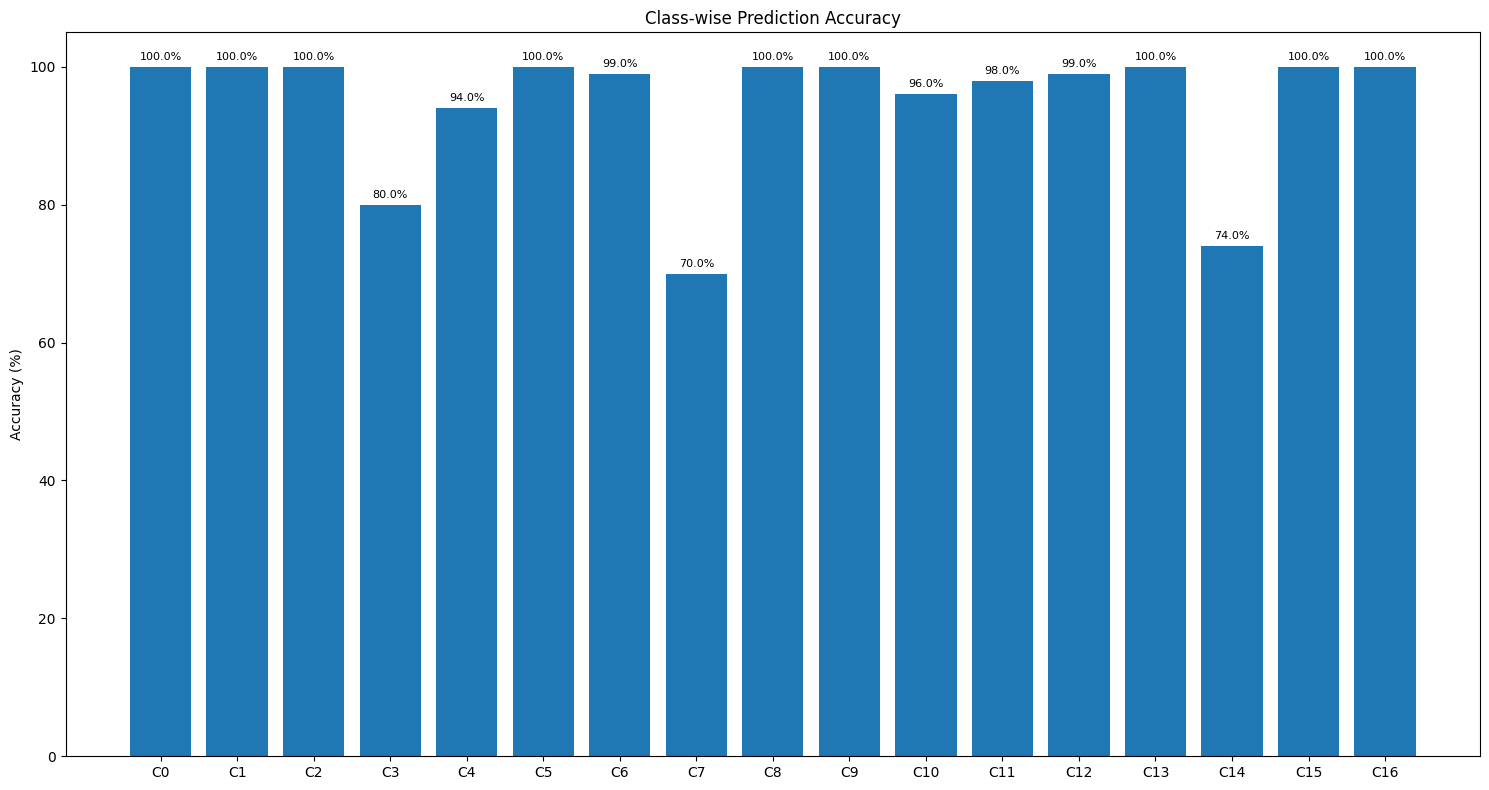

Worst 3 classes:
Class 7: 70.0%
Class 14: 74.0%
Class 3: 80.0%


In [12]:
# 클래스별 성능 시각화
meta_df = pd.read_csv("../data/meta.csv")
avg_acc = {c: np.mean([f.get(c,0) for f in fold_class_accuracies]) for c in range(17)}

plt.figure(figsize=(15, 8))
classes = list(avg_acc.keys())
accs = [avg_acc[c] * 100 for c in classes]
names = [f"C{c}" for c in classes]

plt.bar(range(17), accs)
plt.xticks(range(17), names)
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Prediction Accuracy')
for i, acc in enumerate(accs):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print("Worst 3 classes:")
worst = sorted(avg_acc.items(), key=lambda x: x[1])[:3]
for c, acc in worst:
    print(f"Class {c}: {acc*100:.1f}%")

In [13]:
# 5-Fold 앙상블 모델 준비
ensemble_models = []
for i, state_dict in enumerate(fold_models):
    fold_model = MultiModalModel(model_name, num_classes=17).to(device)
    fold_model.eval()
    ensemble_models.append(fold_model)
print(f"Using ensemble of all {len(ensemble_models)} fold models for inference")

Using ensemble of all 5 fold models for inference


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [14]:
# Temperature Scaling 클래스 정의
class TemperatureScaling(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    
    def forward(self, logits):
        return logits / self.temperature

In [15]:
essential_tta_transforms = [
    # 원본
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 90도 회전들
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[90, 90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[180, 180], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[-90, -90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 밝기 개선
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.RandomBrightnessContrast(brightness_limit=[0.3, 0.3], contrast_limit=[0.3, 0.3], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
]

In [16]:
# TTA 추론을 위한 Dataset 클래스
class TTAImageDataset(Dataset):
    def __init__(self, data, path, transforms, ocr_extractor=None):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.transforms = transforms  # 여러 transform을 리스트로 받음
        self.ocr_extractor = ocr_extractor  # OCR 추출기

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)).convert('RGB'))
        
        # 모든 transform을 적용한 결과를 리스트로 반환
        augmented_images = []
        for transform in self.transforms:
            aug_img = transform(image=img)['image']
            augmented_images.append(aug_img)
        
        # 텍스트 임베딩 추출
        text_embedding = torch.zeros(768)
        if self.ocr_extractor is not None and self.ocr_extractor.available:
            try:
                img_path = os.path.join(self.path, name)
                text = self.ocr_extractor.extract_text_from_image(img_path)
                # 최소한의 텍스트라도 있으면 임베딩, 완전히 비어있으면 "document image"로 대체
                if not text.strip():
                    text = "document image"  # 기본 텍스트
                text_embedding = self.ocr_extractor.get_text_embedding(text)
            except:
                # 실패 시 기본 텍스트로라도 임베딩 생성
                try:
                    text_embedding = self.ocr_extractor.get_text_embedding("document image")
                except:
                    pass
        # 각 TTA에 동일한 텍스트 임베딩 적용
        text_embeddings = [text_embedding] * len(self.transforms)
        
        return augmented_images, target, text_embeddings

In [17]:
# TTA Dataset 생성
tta_dataset = TTAImageDataset(
    "../data/sample_submission.csv",
    "../data/test/",
    essential_tta_transforms,
    ocr_extractor=ocr_extractor  # OCR 추가
)

# TTA DataLoader (배치 크기를 줄여서 메모리 절약)
tta_loader = DataLoader(
    tta_dataset,
    batch_size=64,  # TTA는 메모리를 많이 사용하므로 배치 크기 줄임
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"TTA Dataset size: {len(tta_dataset)}")

TTA Dataset size: 3140


In [18]:
def ensemble_tta_inference(models, loader, transforms, ocr_extractor=None):
    """멀티모달 모델용 5-Fold 앙상블 + TTA 추론"""
    all_predictions = []
    
    for batch_idx, batch_data in enumerate(tqdm(loader, desc="Multimodal Ensemble TTA")):
        if len(batch_data) == 3:  # OCR 포함
            images_list, _, text_embeddings_list = batch_data
        else:  # 이미지만
            images_list, _ = batch_data
            text_embeddings_list = [None] * len(images_list)
        
        batch_size = images_list[0].size(0)
        ensemble_probs = torch.zeros(batch_size, 17).to(device)
        
        # 각 fold 모델별 예측
        for model in models:
            with torch.no_grad():
                # 각 TTA 변형별 예측
                for i, images in enumerate(images_list):
                    images = images.to(device)
                    text_emb = text_embeddings_list[i]
                    if text_emb is not None:
                        text_emb = text_emb.to(device)
                    
                    preds = model(images, text_emb)
                    probs = torch.softmax(preds, dim=1)
                    ensemble_probs += probs / (len(models) * len(images_list))
        
        final_preds = torch.argmax(ensemble_probs, dim=1)
        all_predictions.extend(final_preds.cpu().numpy())
    
    return all_predictions

In [19]:
# 앙상블 TTA 실행
print("Starting Ensemble TTA inference...")
tta_predictions = ensemble_tta_inference(
    models=ensemble_models, 
    loader=tta_loader, 
    transforms=essential_tta_transforms,
    #confidence_threshold=0.9,
    ocr_extractor=ocr_extractor
)

Starting Ensemble TTA inference...


Multimodal Ensemble TTA: 100%|██████████| 50/50 [09:58<00:00, 11.97s/it]


In [20]:
# TTA 결과로 submission 파일 생성
tta_pred_df = pd.DataFrame(tta_dataset.df, columns=['ID', 'target'])
tta_pred_df['target'] = tta_predictions

In [21]:
# 기존 submission과 동일한 순서인지 확인
sample_submission_df = pd.read_csv("../data/sample_submission.csv")
assert (sample_submission_df['ID'] == tta_pred_df['ID']).all()

In [22]:
# TTA 결과 저장
tta_pred_df.to_csv("../submission/choice.csv", index=False)
print("TTA predictions saved")

print("TTA Prediction sample:")

TTA predictions saved
TTA Prediction sample:


In [23]:
tta_pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,10
1,00091bffdffd83de.jpg,7
2,00396fbc1f6cc21d.jpg,7
3,00471f8038d9c4b6.jpg,7
4,00901f504008d884.jpg,14
